# Elastic Search for Text Analysis

* Sie lernen Tools innerhalb ES kenn, die sie unter anderem auch in Ihrer praktischer Arbeit einsetzen können.
* Sie lernen auch hier die Dokumentation von ES kennen, zu lesen und zu verstehen.
  * ES bietet eine Fülle an Endpunkten, mit ebenfalls einer Fülle an Parametern. Ich kann Sie hier nicht alle auflisten. Deshlab ist oft an diesen Stellen auf die Dokumentation verwiesen.

In [1]:
!jupyter nbconvert --to html "elastic search for text analysis.ipynb"

[NbConvertApp] Converting notebook elastic search for text analysis.ipynb to html
[NbConvertApp] Writing 617453 bytes to elastic search for text analysis.html


## Einordnung in die Pipeline

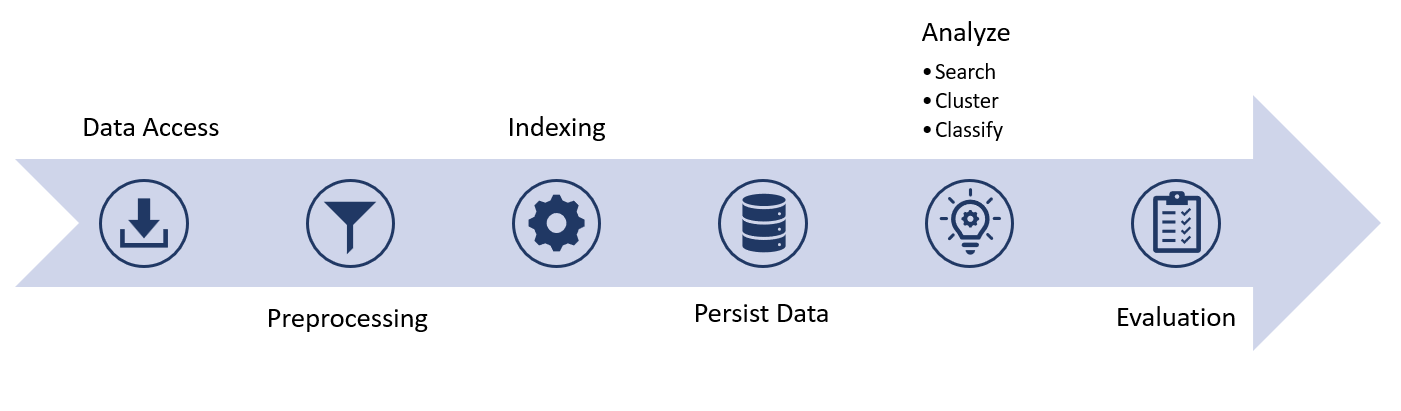

# Inhalt

1. Überblick
2. ES Analyzer
  * Tokenization
  * Token Filterung
  * Konfiguration
3. Ingest Pipelines

# 1. Überblick

* Bisher haben wir den Schritt 2 ausschließlich mit Python bearbeitet
* ES verfügt jedoch auch über Werkzeuge diese Schritte zu übernehmen
  * Tokenization
  * Token Filterung (z.B. Stopfwörter)
  * Normalisierungen

## Use Cases

* Search Engine
* Textanalyse/Textmining
* Untersuchung von Text in einer bestimmten Sprache
* Linguistische Suche

## 2. Elastic Analyzers

* ES bietet eine [ganze Reihe](https://www.elastic.co/guide/en/elasticsearch/reference/7.17/analysis-analyzers.html) an Analyzern zur Auswahl an.
* Analyzer sind in Elastic Funktionen, die in 3 Schritte konfiguriert werden können:
  * Zeichenfilterung
  * Tokenization
  * Tokenfilterung

* Endpoint: `` POST /_anaylize``

Das folgende Beispiel nutzt den [``standard``](https://www.elastic.co/guide/en/elasticsearch/reference/7.17/analysis-standard-analyzer.html)-Analyzer ohne weitere Konfigurationen für die Tokenization von ``text``.

In [36]:
import requests
import json

header = {"Content-Type": "application/json"}
data = {"analyzer": "standard",
        "text": "Hallo, ich bin 30 JAHRE alt."}

res = requests.post("http://localhost:9200/_analyze", data=json.dumps(data), headers=header)

In [37]:
json.loads(res.text)

{'tokens': [{'token': 'hallo',
   'start_offset': 0,
   'end_offset': 5,
   'type': '<ALPHANUM>',
   'position': 0},
  {'token': 'ich',
   'start_offset': 7,
   'end_offset': 10,
   'type': '<ALPHANUM>',
   'position': 1},
  {'token': 'bin',
   'start_offset': 11,
   'end_offset': 14,
   'type': '<ALPHANUM>',
   'position': 2},
  {'token': '30',
   'start_offset': 15,
   'end_offset': 17,
   'type': '<NUM>',
   'position': 3},
  {'token': 'jahre',
   'start_offset': 18,
   'end_offset': 23,
   'type': '<ALPHANUM>',
   'position': 4},
  {'token': 'alt',
   'start_offset': 24,
   'end_offset': 27,
   'type': '<ALPHANUM>',
   'position': 5}]}

#### Der Standard-Analyzer

* Tokenization
  * entfernt Zeichen wie Punkte etc.
* wandelt automatisch in Kleinschreibung um
* Erkennt den Typ eines Tokens, z.B. numerisch, alphanumerisch
* gibt Offsets für Tokens an
* Jeder Analyzer kann zudem konfiguriert werden:
  * Konfiguration eines Tokenizers
  * Tokenfilterung
  * Spezifische Parameter

* Es gibt verschiedene zudem Typen von Analyzern, hier eine Liste der interessantesten:
  * ``whitespace``: Tokenization an Leerzeichen
  * ``standard``: siehe oben
  * ``simple``: Token splitting an jedem nicht-Buchstaben
  * ``pattern``: Token splitting nach Regex (das kennen Sie ja schon gut)
  * ``language``: Konfigurierte Analyzer nach Sprache für u. A. für zusätzliches Stemming und Stopfwortfiltern.

### Konfiguration von Analyzern

* Jeder Analyzer kann beliebig konfiguriert werden:
  * hinzufügen verschiedener Zeichenfilter
  * hinzufügen verschiedener Tokenfilter
  * Normalisierungen wie: lowercase etc.
  
* Im Folgenden wir die Konfiguration eines ``language``-Tokenizer für _german_ vorgestellt.

In [34]:
analyzer_config = {
  "settings": {
    "analysis": {
      "filter": {
        "german_stop": {
          "type":       "stop",
          "stopwords":  "_german_" 
        },
        "german_stemmer": {
          "type":       "stemmer",
          "language":   "light_german"
        }
      },
      "analyzer": {
        "rebuilt_german": {
          "tokenizer":  "standard",
          "filter": [
            "lowercase",
            "german_stop",
            "german_normalization",
            "german_stemmer"
          ]
        }
      }
    }
  }
}

header = {"Content-Type": "application/json"}

res = requests.put("http://localhost:9200/german-index", data=json.dumps(analyzer_config), headers=header)
json.loads(res.text)

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'german-index'}

In [35]:
data = {
  "analyzer": "rebuilt_german",
  "text": "Heute war ein schöner Tag, auch wenn es regnete und die Straße noch nass ist."
}

res = requests.post("http://localhost:9200/german-index/_analyze", data=json.dumps(data), headers=header)
json.loads(res.text)

{'tokens': [{'token': 'heut',
   'start_offset': 0,
   'end_offset': 5,
   'type': '<ALPHANUM>',
   'position': 0},
  {'token': 'schon',
   'start_offset': 14,
   'end_offset': 21,
   'type': '<ALPHANUM>',
   'position': 3},
  {'token': 'tag',
   'start_offset': 22,
   'end_offset': 25,
   'type': '<ALPHANUM>',
   'position': 4},
  {'token': 'regnet',
   'start_offset': 40,
   'end_offset': 47,
   'type': '<ALPHANUM>',
   'position': 8},
  {'token': 'strass',
   'start_offset': 56,
   'end_offset': 62,
   'type': '<ALPHANUM>',
   'position': 11},
  {'token': 'nass',
   'start_offset': 68,
   'end_offset': 72,
   'type': '<ALPHANUM>',
   'position': 13}]}

## Aufgabe

Laden Sie den Country-Corpus in Python, überlassen Sie die Tokenization jedoch Elastic Search! Diese Aufgabe soll Ihnen in erster Linie ein Gefühl über weitere Funktion in ES geben, nicht jedoch die Tokenization neu erfinden.

1. Laden Sie den Country-Corpus in Python. Zum Ausprobieren genügt es auch wenn Sie sich auf 10 Dokumente beschränken.
2. Richten Sie einen Analyzer für die Tokenization in ES ein.
3. Laden Sie die Dokumente in ES. Nutzen Sie den konfigurierten Analyzer für die Tokenization.
4. Welche Tokenization gefällt Ihnen besser, ES oder Python?

# 3. Ingest Pipelines

* Automatisierung von Datentrasnformationen _vor_ dem Indexieren.
* Use Cases:
  * Datenextraktion
  * Datenaufbereitung
  * Datenvalidierung
  * etc...
* Konfigurierbar über die REST-API oder Kibana.
* [Dokumentation](https://www.elastic.co/guide/en/elasticsearch/reference/master/ingest.html)

In [ ]:
# setting css to display svg centered
from IPython.display import display, HTML

CSS = """
.output {
    align-items: center;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [ ]:
from IPython.display import SVG, display
display(SVG(url='https://www.elastic.co/guide/en/elasticsearch/reference/master/images/ingest/ingest-process.svg'))

## Pipeline Processors

* Wie in der Pipeline, die uns die gesamte Veranstaltung begleitet, werden bei Ingest Pipelines in ES die Daten sequentiell einzelnen Arbeitsschritten übergeben.
* Arbeitsschritte werden dabei _Processors_ genannt.
* Der Nutzer kann aus einer Reihe an Prozessoren wählen und daraus seine Pipeline konfigurieren.
* Am Ende der Pipeline werden die verarbeiteten Daten einem zuvor festgegelegten Index übergeben.

#### Auswahl an Processors:

* [Liste in der Dokumentation](https://www.elastic.co/guide/en/elasticsearch/reference/master/processors.html), rechts im Verzeichnis.
* Lowercase / Uppercase
* Convert (Veränderung von Datentypen)
* Read CSV. JSON
* Parse Dates
* und viele, viele mehr...

### Pipeline einrichten mit Kibana

* Stack Management/Ingest Pipelines
* Create Pipeline


``-- Live Demo --``

# Fazit

* Elastic bietet viele Tools für die automatisierte Textverarbeitung
  * Tokenization
  * Filtering
  * Pipelines
* Viele Möglichkeiten zur Textsuche _und_ Gewichtung!
* Schicke GUI (Kibana), flexible & gut dokumentierte Schnittstelle
* Persistenz und Verlässlichkeit

* Das was die Tools können, können Sie jedoch auch schon mit Python umsetzen!
* Jedoch Elastic:
  * Performant
  * Dezentral
  * Können auch "nicht-Programmierer" bedienen (versteht auch Management)
  * Python unabhängig